<a href="https://colab.research.google.com/github/akansh12/Deep-Learning-for-imaging-EE5179/blob/main/Assignment_1/PA1_CS22Z003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification using MLP


By 
- Akansh Maurya (CS22Z003)

Tasks to to:
- Baseline: IP-h(500)-h(250)-h(100)-OP
- Activation functions for hidden layers: Sigmoid and for the Output layer it is softmax
- Gradient-Descent
- lr = 0.01, batch size = 64, epoch = 15
-  Extra marks for experimentations
- Glorot Initialization
- Plot the loss for 200 iterations
- Confustion matrix and classification report
1.1
- Use Tanh and RELU

Task 2:
- Use pytorch for the same
- Add L2 Regularization to it.

###Imports

In [1]:
import tensorflow as tf
import torch
import keras
import torchvision
import numpy as np
from  matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

Downloading the Dataset

In [2]:
# source: https://keras.io/api/datasets/mnist/
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Reshaping the dataset

In [3]:
x_train = np.array(x_train.reshape(x_train.shape[0], 784)).T
x_test = np.array(x_test.reshape(x_test.shape[0], 784)).T
x_train = (x_train/255.0).astype(np.float32)
x_test = (x_test/255.0).astype(np.float32)

In [4]:
print("Train Dataset Shape: ", x_train.shape)
print("Train Target Vector Shape: ", y_train.shape) 
print("Test Dataset Shape:", x_test.shape)
print("Test Target Vector Shape", y_test.shape)

Train Dataset Shape:  (784, 60000)
Train Target Vector Shape:  (60000,)
Test Dataset Shape: (784, 10000)
Test Target Vector Shape (10000,)


9
7


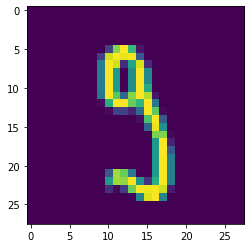

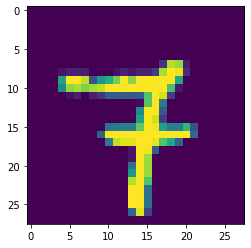

In [6]:
plt.figure()
plt.imshow(x_train[:,48].reshape(28,28))
print(y_train[48])
plt.figure()
plt.imshow(x_test[:,75].reshape(28,28))
print(y_test[75])

In [50]:
class MLP():
  def __init__(self, epochs, num_input_nodes, hidden_layers, num_output_nodes, lr, optimizer, batch_size, activation_function = 'sigmoid', loss_type = 'cross_entropy', w_initial = 'glorot'):
    self.epochs = epochs
    self.lr = lr 
    self.optimizer = optimizer
    self.optimizer.lr = self.lr      
    self.batch_size = batch_size
    self.num_input_nodes = num_input_nodes
    self.hidden_layers = hidden_layers
    self.num_output_nodes = num_output_nodes
    self.loss_type = loss_type
    #Activation function
    self.activation_function = self.activation(activation_function)
    #parameter initialization
    self.params = self.initialization(weight_initialisation = w_initial)

  def activation(self, activation_function):

    if activation_function == 'sigmoid':
      return self.sigmoid
    if activation_function == 'tanh':
      return self.tanh
    if activation_function == 'ReLU':
      return self.relu

  def sigmoid(self,x, derivative = False):
    if derivative:
      return self.sigmoid(x)*(1-self.sigmoid(x))
    else:
      return 1/(1 + np.exp(-x))

  def tanh(self, x, derivative = False):
    if derivative:
      return 1 - self.tanh(x)**2
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

  def relu(self, x, derivative = False):
    if derivative:
      return (x>0)*1 
    return x*(x>0)


  def one_hot(self,y):
    v = np.zeros((self.num_output_nodes, len(y)))
    for i,j in enumerate(y):
      v[j,i] = 1
    return v

  def softmax(self,x,derivative = False):
    if derivative:
      return self.softmax(x)*(1- self.softmax(x))
    else:
      return (np.exp(x)/np.sum(np.exp(x), axis = 0))

  def loss(self, y_pred, y_true):
    if self.loss_type == 'cross_entropy':
      return -1*np.sum(np.multiply(self.one_hot(y_true), np.log(y_pred))) # To Do: Optimize this using argmax

  def initialization(self, weight_initialisation = 'random'):
    w = []
    b = []

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*0.1)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*np.sqrt(2/(self.num_input_nodes+self.hidden_layers[0])))
    b.append(np.zeros((self.hidden_layers[0], 1))) 

    for i in range(1,len(self.hidden_layers)):
      if weight_initialisation == 'random':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*0.1)
      elif weight_initialisation == 'Xavier':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*np.sqrt(2/(self.hidden_layers[i-1]+self.hidden_layers[i])))
      b.append(np.zeros((self.hidden_layers[i], 1)))

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*0.1)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*np.sqrt(2/(self.hidden_layers[len(self.hidden_layers)-1] + self.num_output_nodes)))
    b.append(np.zeros((self.num_output_nodes, 1)))

    return {'w':w, 'b':b}

  def compute_accuracy(self, x_test, y_test):
    from sklearn.metrics import accuracy_score
    out = self.feed_forward(x_test)
    pred = np.argmax(out, axis = 0)
    acc=accuracy_score(y_test, pred, normalize=True, sample_weight=None)
    return np.mean(pred == y_test)*100

  def feed_forward(self, x):
    #a=wh+b
    #h=activation function(a)
    self.a = []
    self.h = []
    self.h.append(x)

    for i in range(0, len(self.hidden_layers)):
      self.a.append(np.dot(self.params['w'][i], self.h[-1])+ self.params['b'][i])
      self.h.append(self.activation_function(self.a[i]))

    self.a.append(np.dot(self.params['w'][-1],self.h[-1])+self.params['b'][-1])

    y_hat = self.softmax(self.a[-1])
    return y_hat

  def back_propagation(self, y_hat, y_true):
    self.da = [0]* len(self.a)
    self.dh = [0]* (len(self.h)-1)
    self.dw = [0]* len(self.params['w'])
    self.db = [0]* len(self.params['b'])

    self.da[-1] = -1*(y_true - y_hat)

    for i in range(len(self.params['w'])-1, 0, -1):
      self.dw[i] = np.dot(self.da[i], self.h[i].T) 
      self.db[i] = self.da[i]

      self.dh[i-1] = np.dot(self.params['w'][i].T, self.da[i])
      self.da[i-1] = np.multiply(self.dh[i-1], self.activation_function(self.da[i-1], derivative=True))
    self.dw[0] = self.da[0], self.dh[0].T
    self.db[0] = self.da[0]

    return self.dw, self.db

  def train(self, x_train, y_train, x_test, y_test):
    N = x_train.shape[1]
    n_batches = int(np.floor(N / self.batch_size))
    train_iter_loss = []
    test_iter_loss = []
    train_epoch_loss = []
    for epoch in range(0, self.epochs):
      l = 0
      for batch in tqdm(range(0, n_batches)):
        x = x_train[:,batch*self.batch_size:self.batch_size+batch*self.batch_size]
        y = y_train[batch*self.batch_size:self.batch_size+batch*self.batch_size]
        y_hat = self.feed_forward(x)

        gW, gB = self.back_propagation(y_hat,self.one_hot(y))
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(y_hat, self.one_hot(y))
        if batch % 200 == 0:
          train_iter_loss.append(self.loss(self.feed_forward(x_train)),self.one_hot(y_train))
          test_iter_loss.append(self.loss(self.feed_forward(x_test)),self.one_hot(y_test))

      try:
        x = x_train[:,-1*N%n_batches:]
        y = y_train[-1*N%n_batches:]
        y_hat = self.feed_forward(x)
        gW, gB = self.back_propagation(y_hat, self.one_hot(y))
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(y_hat, y)
      except:
        pass

      train_epoch_loss.append(l/N)
      print(f"Epoch: {epoch}, Epoch-loss: {l/N}")
      print(f"Train Accuracy: {self.compute_accuracy(x_train, y_train)}")
      print(f"Test Accuracy: {self.compute_accuracy(x_test, y_test)}")

    return train_iter_loss, test_iter_loss, train_epoch_loss
    


In [22]:
### Optimizer
class SGD:
  ''' Stochastic Gradient Descent '''
  def __init__(self, lr = 0.001):
    self.lr = lr
      
  def update(self, params, gW, gB):
    W = np.array(params['w'], dtype = object)
    B = np.array(params['b'], dtype = object)
    print(W.shape)
    print(np.array(gW, dtype = object).shape)
    W = (1)*W - self.lr * np.array(gW, dtype = object)
    B = (1)*B - self.lr * np.array(gB, dtype = object)

    return {'w':W.tolist(), 'b': B.tolist()}

In [51]:
model = MLP(epochs = 5,num_input_nodes = 784, hidden_layers = [1024, 2048, 256],num_output_nodes = 10, lr = 0.001, optimizer = SGD(), batch_size= 64, w_initial = 'random', activation_function = 'sigmoid',loss_type='cross_entropy')

In [32]:
for i in range(0,4):
  print(model.params['w'][i].shape)
  print(model.params['b'][i].shape)

(1024, 784)
(1024, 1)
(2048, 1024)
(2048, 1)
(256, 2048)
(256, 1)
(10, 256)
(10, 1)


In [34]:
x_train.shape

(784, 60000)

In [52]:
y_hat = model.feed_forward(x_train[:,:16])

In [53]:
dw, db = model.back_propagation(y_hat, model.one_hot(y_train[:16]))

In [58]:
params = model.optimizer.update(model.params, dw,db)

(4,)
(4,)


TypeError: ignored